# Summary

## RoBERTa

# Code

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install -q transformers==4.37.2

# !pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 14.7 MB/s eta 0:00:00


In [2]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel, XLMRobertaTokenizer, TFXLMRobertaModel, TFLongformerModel, LongformerTokenizer
from transformers import InputExample, InputFeatures
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

## Load Data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


In [4]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [5]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [6]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [7]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [8]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [9]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [10]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [11]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [12]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

In [13]:
# maximum comment length for train_texts
train_texts_max_length = max(train_texts.str.len())
train_texts_max_length

5000

In [14]:
# maximum comment length for train_texts
test_texts_max_length = max(test_texts.str.len())
test_texts_max_length

5000

##RoBERTa

### XLM-RoBERTa

XLM-RoBERTa is available through the Hugging Face Transformers library, making it easy to use for various tasks like text classification, named entity recognition, and more across multiple languages

In [21]:
# Load tokenizer and model
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlm_model = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [16]:
# max_sequence_length=256
max_sequence_length=512

# Define the early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [17]:
train_encodings = xlm_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_sequence_length, return_tensors='tf')
valid_encodings = xlm_tokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_sequence_length, return_tensors='tf')
test_encodings = xlm_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_sequence_length, return_tensors='tf')

NameError: name 'xlm_tokenizer' is not defined

In [25]:
def create_xlmroberta_binary_classification_model(max_sequence_length=max_sequence_length,
                                                  hidden_size=275,
                                                  learning_rate=0.00001):
    """
    Build a binary classification model with XLM-RoBERTa.
    """

    # Define the input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    # Load the pre-trained XLM-RoBERTa model
    xlmroberta_model = TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')
    # Optionally make XLM-RoBERTa layers trainable
    xlmroberta_model.trainable = True

    # Retrieve the last hidden state of the token sequence
    outputs = xlmroberta_model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state

    # Typically, the 'CLS' token's output is used for classification tasks
    cls_token_output = last_hidden_state[:, 0, :]

    # Optionally, add a hidden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu')(cls_token_output)

    # Output layer for binary classification
    classification_output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    # Compile the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [26]:
xlmroberta_model = create_xlmroberta_binary_classification_model()

xlmroberta_model_model_history = xlmroberta_model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2,
    callbacks=[earlystop]
)

config.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Epoch 1/2


6383/6383 [==============================] - 6728s 1s/step - loss: 0.1183 - accuracy: 0.9557 - val_loss: 0.1021 - val_accuracy: 0.9638
Epoch 2/2
6383/6383 [==============================] - 6700s 1s/step - loss: 0.0800 - accuracy: 0.9682 - val_loss: 0.1031 - val_accuracy: 0.9648


In [27]:
xlmroberta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 tfxlm_roberta_model_1 (TFX  TFBaseModelOutputWithPooli   2780436   ['input_ids_layer[0][0]',     
 LMRobertaModel)             ngAndCrossAttentions(last_   48         'attention_mask_layer[0][

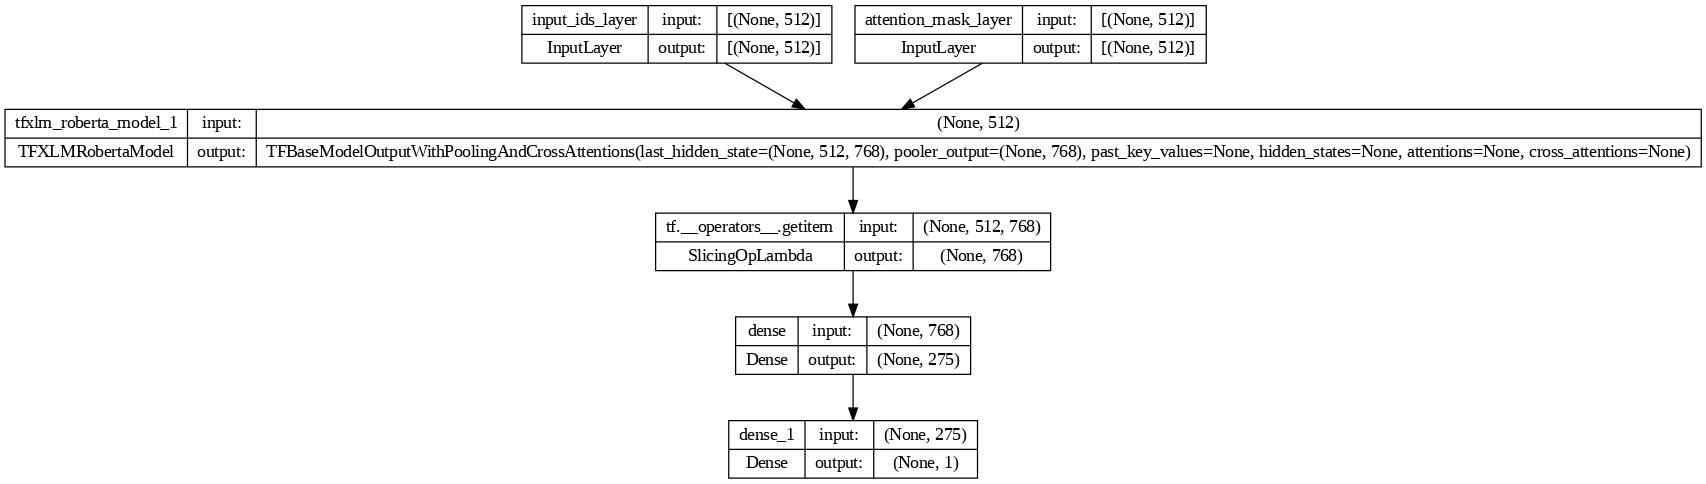

In [28]:
keras.utils.plot_model(xlmroberta_model, show_shapes=True, dpi=90)

800/800 [==============================] - 976s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     23130
           1       0.58      0.83      0.69      2461

    accuracy                           0.93     25591
   macro avg       0.78      0.89      0.82     25591
weighted avg       0.94      0.93      0.93     25591

ROC AUC Score: 0.9663924889319646


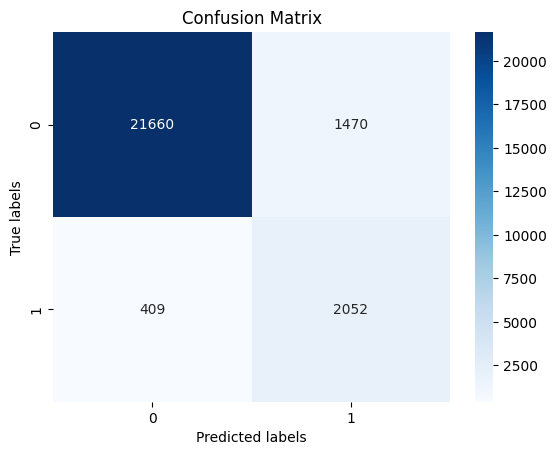

In [29]:
# Make predictions
predictions = xlmroberta_model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# def create_xlmroberta_model(max_sequence_length=max_sequence_length,
#                              num_filters=[131, 127, 51, 23, 17],
#                              kernel_sizes=[2, 3, 4, 5, 7],
#                              dropout=0.3,
#                              hidden_size=275,
#                              learning_rate=0.00001):
#     """
#     Build a classification model with XLM-RoBERTa, where you apply CNN layers to the XLM-RoBERTa output
#     """

#     # Load XLM-RoBERTa model
#     xlmroberta_model = TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')

#     # Ensure the XLM-RoBERTa model's layers are set as trainable
#     xlmroberta_model.trainable = True

#     input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

#     # Retrieve embeddings
#     xlmroberta_inputs  = {'input_ids': input_ids, 'attention_mask': attention_mask}
#     xlmroberta_outputs  = roberta_model(xlmroberta_inputs)
#     last_hidden_state = xlmroberta_outputs.last_hidden_state

#     # CNN layers
#     cnn_input = last_hidden_state

#     conv_layers_for_all_kernel_sizes = []
#     for kernel_size, filters in zip(kernel_sizes, num_filters):
#         conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_input)
#         conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
#         conv_layers_for_all_kernel_sizes.append(conv_layer)

#     conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

#     # Dropout and Dense layers
#     hidden = tf.keras.layers.Dropout(dropout)(conv_output)

#     classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

#     classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

#     classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#                                  metrics=['accuracy'])

#     return classification_model

In [ ]:
# xlmroberta_cnn_model = create_xlmroberta_model()

# xlmroberta_cnn_model_history = xlmroberta_cnn_model.fit(
#     [train_encodings.input_ids, train_encodings.attention_mask],
#     train_labels,
#     validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
#     batch_size=16,
#     epochs=2,
#     callbacks=[earlystop]
# )

### RoBERTa-Long

In [31]:
max_sequence_len = 1500

# Initialize the Longformer tokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Tokenize the datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_sequence_len, return_tensors='tf')
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_sequence_len, return_tensors='tf')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_sequence_len, return_tensors='tf')


In [32]:
len(train_encodings.input_ids[0])

1500

In [35]:
def create_longformer_binary_classification_model(max_sequence_length=max_sequence_len,
                                                  hidden_size=275,
                                                  learning_rate=0.00005):
    """
    Build a binary classification model with Longformer capable of handling longer sequences.
    """

    # Define the input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    # Load the pre-trained Longformer model
    longformer_model = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')
    # Make Longformer layers trainable
    longformer_model.trainable = True

    # Retrieve the last hidden state
    outputs = longformer_model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state

    # Use the 'CLS' token's output for classification tasks
    cls_token_output = last_hidden_state[:, 0, :]

    # Optionally, add a hidden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu')(cls_token_output)

    # Output layer for binary classification
    classification_output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    # Compile the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [36]:
roberta_long_model = create_longformer_binary_classification_model()

roberta_long_model_history = roberta_long_model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2,
    callbacks=[earlystop]
)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node model_4/tf_longformer_model_4/longformer/encoder/layer_._4/attention/self/Roll defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-36-315a5d5eed01>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 2156, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 2155, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 2156, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1880, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1684, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1689, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1633, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1594, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 841, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1060, in _sliding_chunks_query_key_matmul

Detected at node model_4/tf_longformer_model_4/longformer/encoder/layer_._4/attention/self/Roll defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-36-315a5d5eed01>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 2156, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 2155, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 2156, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1880, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1684, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1689, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1633, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1594, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 841, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/longformer/modeling_tf_longformer.py", line 1060, in _sliding_chunks_query_key_matmul

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[96,5,512,513] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/tf_longformer_model_4/longformer/encoder/layer_._4/attention/self/Roll}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model_4/tf_longformer_model_4/longformer/encoder/layer_._7/attention/self/cond_2/pivot_f/_984/_2227]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[96,5,512,513] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/tf_longformer_model_4/longformer/encoder/layer_._4/attention/self/Roll}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_478929]

In [ ]:
roberta_long_model.summary()

In [ ]:
keras.utils.plot_model(roberta_long_model, show_shapes=True, dpi=90)

In [ ]:
# Make predictions
predictions = roberta_long_model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()